In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
from sklearn.preprocessing import LabelEncoder
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from data_access.load_file import load_table, dict_to_df
from data_preparation import compute_work_item_times
from data_processing.functions import time_for_phase, set_end_date
from data_processing import features

First we load and preprocess the data

In [3]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
total_times = compute_work_item_times(data)
times = time_for_phase(data, end_date="2018-03-31", process=False)
times.dropna(inplace=True)

In [4]:
open_wis = total_times[pd.isnull(total_times["duration_in_days"])]["work_item"].values
times_open = times[times.work_item.isin(open_wis)]
times_closed = times[~times.work_item.isin(open_wis)]
times_closed.dropna(inplace=True)
times_closed.loc[:, "receive_date"] = times_closed["from_timestamp"].apply(lambda x: x.date())
times_closed.loc[:, "drop_date"] = times_closed["to_timestamp"].apply(lambda x: x.date())

In [5]:
times.loc[:, "receive_date"] = times["from_timestamp"].apply(lambda x: x.date())
times.loc[:, "drop_date"] = times["to_timestamp"].apply(lambda x: x.date())
daterange = pd.date_range(start=str(times["receive_date"].min()), end=str(times["drop_date"].max()), freq='D')

For easier handling we assume every working step to be closed until the last day in the dataset.

We now want to compute a measure for the experience of an employee. We define it as follow:

\begin{equation}
x^{er}_{exp}(t) = \frac{t_{spent}\sum{w^{er}_{closed}(t)}}{\sum{w_{closed}(t)}}
\end{equation}

We also want to define a measure for the workload of an employee:

\begin{equation}
x^{er}_{load}(t) = \frac{\sum{w^{er}_{open}(t)}}{\sum{w_{open}(t)}}
\end{equation}

with $t$ as time, $t_{spent}$ as time already spend in the company, $w$ being a working step and $er$ being a resource.

In [6]:
def x_experience(times, resource, t, col="current_resource"):
    assert col in times.columns, col + " not in columns of dataframe"
    
    closed_tickets = times[times["receive_date"] < t]
    er = closed_tickets[closed_tickets[col] == resource]
    
    try:
        date_diff = (t - er["receive_date"].min())
        working_time = round(date_diff.total_seconds() / (24*3600), 2)
    except TypeError:
        working_time = 1
    if pd.isna(working_time):
        working_time = 1
    
    try:
        x_exp = (working_time*len(er))/len(closed_tickets)
    except ZeroDivisionError:
        x_exp = 0
        
    return x_exp    

In [7]:
def x_workload(times, resource, t, col="current_resource"):
    assert col in times.columns, col + " not in columns of dataframe"
    
    open_tickets = times[(times["receive_date"] <= t) &
                         (times["drop_date"] >= t)]
    er = open_tickets[open_tickets[col] == resource]
    
    try:
        x_load = (len(er))/len(open_tickets)
    except ZeroDivisionError:
        x_load = 0
        
    return x_load

We are going to test the functions with the most frequent resource.

In [8]:
resource = "ER_00061"
plot_df = pd.DataFrame(index=daterange, columns=["x_exp", "x_load"])
for date in daterange:
    plot_df.loc[date, "x_exp"] = x_experience(times, resource, date.date())
    plot_df.loc[date, "x_load"] = x_workload(times, resource, date.date())

The function runs without errors. We want to plot the results, the graph should show an increasing trend for the experience and some kind of fluktuation for the workload.

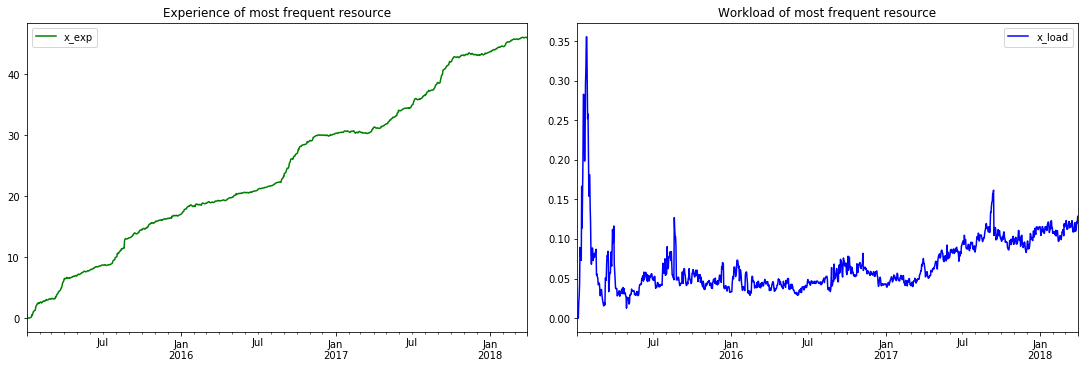

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, constrained_layout=True)
plot_df["x_exp"].plot(color='g', ax=ax[0], label="x_exp")
plot_df["x_load"].plot(color='b', ax=ax[1], label="x_load")
ax[0].set_title("Experience of most frequent resource")
ax[1].set_title("Workload of most frequent resource")
ax[0].legend()
ax[1].legend()
plt.show()

Now we are able to compute the two measures for every resource for a given time. To add this as a feature to our model we also need a function to aggregate the measures regarding to the multiple resources working on one work item. We define the following as the employment rate for every work item:

\begin{equation}
x^{wi}_{emp} = \frac{\sum_{er}{x^{er}_{exp}(t)x^{er}_{load}(t)}}{\sum_{er}{w^{er}}}
\end{equation}

with $t$ as the time the employee recieves the task.

In [10]:
def employment_rate(times, work_item, resource_col="current_resource"):
    assert resource_col in times.columns, resource_col + " not in columns of dateframe!"
    
    wi = times[times["work_item"] == work_item]
    resources = list(wi[resource_col].values)
    res_counter = defaultdict(int)
    numerator = 0
    x_exp_sum = 0
    x_load_sum = 0
    denumerator = len(resources)
    
    for resource in resources:
        if resources.count(resource) > 1:
            res_counter[resource] += 1
            t = wi[wi[resource_col] == resource]["receive_date"].iloc[res_counter[resource]-1]
        elif resources.count(resource) == 1:
            t = wi[wi[resource_col] == resource]["receive_date"].values[0]
        x_exp = x_experience(times, resource, t, resource_col)
        x_load = x_workload(times, resource, t, resource_col)
        x_exp_sum += x_exp
        x_load_sum += x_load
        numerator += (x_exp * x_load)

    x_emp = numerator/denumerator
    x_ex = x_exp_sum/denumerator
    x_l = x_load_sum/denumerator
    return x_emp, x_ex, x_l

Now we want to compute the measures for every work item and compare them

In [11]:
x_emp, x_exp, x_load = employment_rate(times, "WI_000001")

In [12]:
# res_df = pd.DataFrame(index=times.work_item.unique(), columns=["x_emp", "x_exp", "x_load"])
# counter = 0
# for wi in times.work_item.unique():
#     x_emp, x_exp, x_load = employment_rate(times, wi)
#     res_df.loc[wi, "x_emp"] = x_emp
#     res_df.loc[wi, "x_exp"] = x_exp
#     res_df.loc[wi, "x_load"] = x_load
#     counter += 1
#     if counter == 500:
#         print("500 work items done!")
#         counter = 0

Computation takes a while. We will write the data to the SQL-Server so we don't have to compute them every time.

In [14]:
# import sqlalchemy
# engine = sqlalchemy.create_engine("XXX")
# con = engine.connect()
# # tosql = res_df.reset_index().rename(columns={"index":"work_item"})
# # tosql.to_sql(name="resource_employment_rate", con=con)
# res_df = pd.read_sql_table(table_name="resource_employment_rate", con=con)
# con.close()

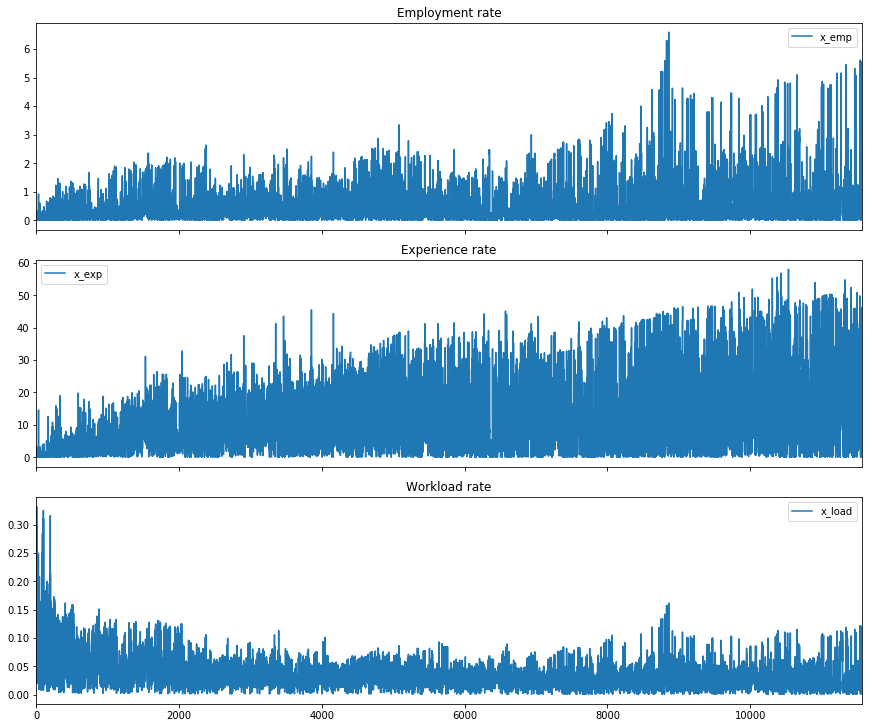

In [14]:
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True, constrained_layout=True)
res_df["x_emp"].plot(ax=ax[0], label="x_emp")
ax[0].set_title("Employment rate")
ax[0].legend()
res_df["x_exp"].plot(ax=ax[1], label="x_exp")
ax[1].set_title("Experience rate")
ax[1].legend()
res_df["x_load"].plot(ax=ax[2], label="x_load")
ax[2].set_title("Workload rate")
ax[2].legend()
plt.show()

We want to add another feature regarding to the difficulty of a work item. Resources have days where they are closing a lot of items at once. But there are always some items that are skipping these 'closing days' so we assume that these items have a higher difficulty.

We define a closing day as
\begin{equation}
t^{er}_{close} =
\begin{cases} 
      1 & \frac{\sum{w^{er}_{closed}(t)}}{\sum{w^{er}_{open}(t)}} \geq 0.25 \\
      0 & else 
\end{cases}
\end{equation}

So if 30% of the open tickets the resource holds are closed it's a closing day. We define than the difficulty of a work item

\begin{equation}
x^{wi}_{diff} = \sum_{t}{\sum_{er}{t^{er}_{close}}}
\end{equation}

The difficulty is the sum of all closing days a work item skipped for every resource that worked on it.

Now let's implement this.

In [15]:
def calc_t_close(times_closed, resource):
    res_df = times_closed[times_closed["current_resource"] == resource]
#     We calculate the number of items dropped at a drop date
    t_close = pd.DataFrame(res_df["drop_date"].value_counts()).reset_index().rename(columns={"index":"drop_date",
                                                                                             "drop_date":"w_closed"})
#     We calculate the work items that are open over a drop date
    res_df["w_open"] = res_df["drop_date"].apply(lambda t: res_df[(res_df["drop_date"].apply(lambda x: x>=t)) & 
                                                           (res_df["receive_date"].apply(lambda x: x<=t))].shape[0])
#     Now we merge them together and calculate the percentage
    t_close = pd.merge(t_close, res_df[["drop_date", "w_open"]].drop_duplicates())
    t_close.loc[:, "percentage_closed"] = t_close["w_closed"] / t_close["w_open"].apply(lambda x: 1 if x==0 else x)
    t_close.loc[:, "t_close"] = t_close["percentage_closed"].apply(lambda x: 1 if x >= 0.25 else 0)
    close_days = t_close[t_close["t_close"] == 1]["drop_date"].values
    return close_days

In [16]:
times.loc[:, "x_diff"] = 0
for resource in times["current_resource"].unique():
    close_days = calc_t_close(times_closed, resource)
    res_df = times[times["current_resource"] == resource]
    for x, y in res_df.iterrows():
        difficulty = len([e for e in close_days if ((y["receive_date"]<e)&~(y["drop_date"]<=e))])
        times.loc[x, "x_diff"] = difficulty

In [17]:
difficulty_df = pd.DataFrame(times.groupby("work_item")["x_diff"].sum()).reset_index()
plot_df = pd.merge(total_times.dropna(), difficulty_df).drop_duplicates()
total_times_c = compute_work_item_times(set_end_date(data, "2018-03-31"))
plot_df_open = pd.merge(total_times_c[total_times_c.work_item.isin(open_wis)], difficulty_df).drop_duplicates("work_item")

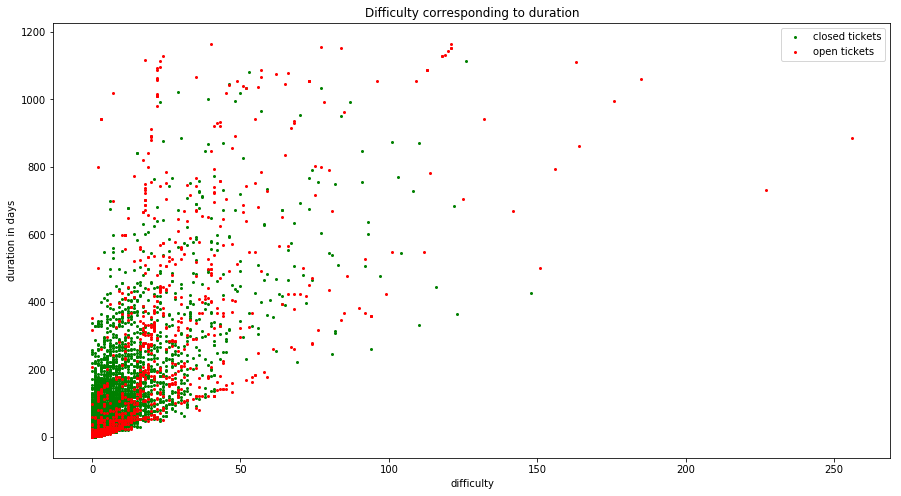

In [18]:
plt.figure(figsize=(15,8))
plt.scatter(x=plot_df.x_diff, y=plot_df.duration_in_days, s=4, color='g', label="closed tickets")
plt.scatter(x=plot_df_open.x_diff, y=plot_df_open.duration_in_days, s=4, color='r', label="open tickets")
plt.title("Difficulty corresponding to duration")
plt.xlabel("difficulty")
plt.ylabel("duration in days")
plt.legend()
plt.show()

Now the difficulty is only resource related and has a wide range of values. We should think about a better scale for that.